In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

/Users/abhinavsinha/Desktop/vscode/Genai_projects/ANN_Model_Repo/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv") 

In [3]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
# Drop missing values in train dataset
train_df = train_df.dropna(subset=['text', 'target'])

In [5]:
# Prepare training and validation datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_df['text'].tolist(), train_df['target'].tolist(), test_size=0.2, random_state=42)

In [6]:
# Tokenize text using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [7]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [8]:
# Create Dataset class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [9]:
# Load DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(axis=1)),
        'classification_report': classification_report(p.label_ids, p.predictions.argmax(axis=1), output_dict=True)
    }
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./distilbert_sentiment')
tokenizer.save_pretrained('./distilbert_sentiment')

/Users/abhinavsinha/Desktop/vscode/Genai_projects/ANN_Model_Repo/venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/39/t_gssy551ls2w2r5zf8df85w0000gn/T/ipykernel_75192/2834487584.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Classification Report
1,0.298500,0.401926,0.825345,"{'0': {'precision': 0.8377777777777777, 'recall': 0.8627002288329519, 'f1-score': 0.8500563697857948, 'support': 874.0}, '1': {'precision': 0.8073836276083467, 'recall': 0.7750385208012327, 'f1-score': 0.7908805031446541, 'support': 649.0}, 'accuracy': 0.8253447143795141, 'macro avg': {'precision': 0.8225807026930623, 'recall': 0.8188693748170923, 'f1-score': 0.8204684364652244, 'support': 1523.0}, 'weighted avg': {'precision': 0.8248258385394582, 'recall': 0.8253447143795141, 'f1-score': 0.8248396019262411, 'support': 1523.0}}"
2,0.271500,0.429956,0.839133,"{'0': {'precision': 0.8392664509169363, 'recall': 0.8901601830663616, 'f1-score': 0.863964464186563, 'support': 874.0}, '1': {'precision': 0.8389261744966443, 'recall': 0.7704160246533128, 'f1-score': 0.8032128514056225, 'support': 649.0}, 'accuracy': 0.8391332895600788, 'macro avg': {'precision': 0.8390963127067903, 'recall': 0.8302881038598372, 'f1-score': 0.8335886577960927, 'support': 1523.0}, 'weighted avg': {'precision': 0.8391214480300226, 'recall': 0.8391332895600788, 'f1-score': 0.8380762194755778, 'support': 1523.0}}"
3,0.246400,0.529840,0.839133,"{'0': {'precision': 0.8529741863075196, 'recall': 0.8695652173913043, 'f1-score': 0.8611898016997167, 'support': 874.0}, '1': {'precision': 0.819620253164557, 'recall': 0.7981510015408321, 'f1-score': 0.8087431693989071, 'support': 649.0}, 'accuracy': 0.8391332895600788, 'macro avg': {'precision': 0.8362972197360383, 'recall': 0.8338581094660682, 'f1-score': 0.834966485549312, 'support': 1523.0}, 'weighted avg': {'precision': 0.8387609869576951, 'recall': 0.8391332895600788, 'f1-score': 0.8388405801874217, 'support': 1523.0}}"


Trainer is attempting to log a value of "{'0': {'precision': 0.8377777777777777, 'recall': 0.8627002288329519, 'f1-score': 0.8500563697857948, 'support': 874.0}, '1': {'precision': 0.8073836276083467, 'recall': 0.7750385208012327, 'f1-score': 0.7908805031446541, 'support': 649.0}, 'accuracy': 0.8253447143795141, 'macro avg': {'precision': 0.8225807026930623, 'recall': 0.8188693748170923, 'f1-score': 0.8204684364652244, 'support': 1523.0}, 'weighted avg': {'precision': 0.8248258385394582, 'recall': 0.8253447143795141, 'f1-score': 0.8248396019262411, 'support': 1523.0}}" of type <class 'dict'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'0': {'precision': 0.8392664509169363, 'recall': 0.8901601830663616, 'f1-score': 0.863964464186563, 'support': 874.0}, '1': {'precision': 0.8389261744966443, 'recall': 0.7704160246533128, 'f1-score': 0.80321285140

('./distilbert_sentiment/tokenizer_config.json',
 './distilbert_sentiment/special_tokens_map.json',
 './distilbert_sentiment/vocab.txt',
 './distilbert_sentiment/added_tokens.json')

In [11]:
# Load test dataset
test_texts = test_df['text'].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)
test_dataset = NewsDataset(test_encodings, [0] * len(test_texts))  # Dummy labels for testing

# Load trained model
model = DistilBertForSequenceClassification.from_pretrained('./distilbert_sentiment')

# Perform predictions
trainer = Trainer(model=model, tokenizer=tokenizer)
predictions = trainer.predict(test_dataset)

# Add predictions to test DataFrame
test_df['target'] = predictions.predictions.argmax(axis=1)

# Save to CSV
test_df.to_csv("test_predictions.csv", index=False)

/var/folders/39/t_gssy551ls2w2r5zf8df85w0000gn/T/ipykernel_75192/3980207497.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Accuracy: 0.8253

Classification Report:
                   precision    recall  f1-score   support

Not Disaster (0)       0.84      0.86      0.85       874
    Disaster (1)       0.81      0.78      0.79       649

        accuracy                           0.83      1523
       macro avg       0.82      0.82      0.82      1523
    weighted avg       0.82      0.83      0.82      1523



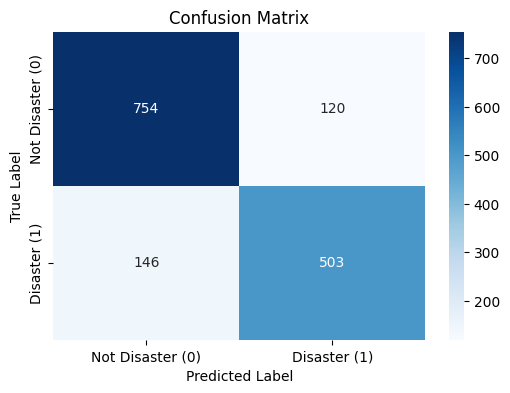

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the validation dataset
val_predictions = trainer.predict(val_dataset)

# Extract the predicted labels and true labels
pred_labels = np.argmax(val_predictions.predictions, axis=1)
true_labels = val_labels

# 1. Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# 2. Classification Report
report = classification_report(true_labels, pred_labels, target_names=["Not Disaster (0)", "Disaster (1)"])
print("\nClassification Report:\n", report)

# 3. Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Disaster (0)", "Disaster (1)"], yticklabels=["Not Disaster (0)", "Disaster (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()